In [1]:
from networkx.readwrite.json_graph import adjacency
import orbax.checkpoint as ocp
import jax
import numpy as np
from jax import numpy as jnp
from pathlib import Path
from attack import keep_indices, _take_square, _take_vec
import matplotlib.pyplot as plt
from measures import entropic_measures,lz_complexity_measures, sample_entropy_measures, global_metrics_directed
from utils import plot_raster_simple
import networkx as nx 
import time
from importlib import metadata

In [96]:
base_dir = Path("save/ER_dense_stdp").resolve()
base_dir.mkdir(parents=True, exist_ok=True)

n_of_directories =len([d for d in base_dir.iterdir() if d.is_dir()])


In [97]:
base_dir/'0'

PosixPath('/Users/mauffee/Projects/resinets/rnjax/src/save/ER_dense_stdp/0')

In [110]:
from tqdm import tqdm 
def take_submatrix(M: np.ndarray, idx: np.ndarray) -> np.ndarray:
    # np.ix_(idx, idx) creates a pair of index arrays shaped so that broadcasting works properly
    return M[np.ix_(idx, idx)]

step = 0
I_ext = 10.0

with ocp.CheckpointManager(base_dir) as mngr:
    time_start = time.time()
    all_emsrs = []
    all_lz = []
    all_sp = []
    all_gm = []
    restored = mngr.restore(step)
    print(restored.arrays.keys())

    base_S_hist = restored.arrays['base_S_hist'] # shape: (T, N)
    pruned_S_hist_batch = restored.arrays['pruned_S_hist_batch'] # shape: (B, T, N)
    W0 = np.array(restored.arrays['W0']) # shape: (N, N)
    removed_ids = restored.arrays['removed_ids'] # Shape (B, n removed neurons)
    neuron_type = restored.arrays['neuron_type'] # shape: (N,)
    n_nodes = restored.metadata['parameters']['N']

    pre_G_reconstructed = nx.from_numpy_array(W0, create_using=nx.DiGraph)
    gm0 = global_metrics_directed(pre_G_reconstructed)

    
    base_driver_fraction = restored.arrays['base_driver_fraction']
    ##mean_abs_syn = np.mean(np.abs(base_syn_hist))      # average across time & neurons
    #base_driver_fraction = mean_abs_syn / (mean_abs_syn + I_ext)
    
    all_drf = []

    #fig, ax_raster,orders = plot_raster(base_S_hist, neuron_type, W0,base_S_hist.shape[0], mode='mask')

    for batch in tqdm(range(removed_ids.shape[0])):
        take_idx = keep_indices(removed_ids[batch], n_nodes)

        # Needs to be numpy for measure libs infomeasure and Antropy
        pre_attack_S = np.array(base_S_hist)
        post_attack_S = np.array(pruned_S_hist_batch[batch])
        
        post_attack_W = take_submatrix(W0, take_idx)

        emsrs = entropic_measures(pre_attack_S, post_attack_S, take_idx)
        
        lz = lz_complexity_measures(pre_attack_S, post_attack_S, take_idx)
        sp = sample_entropy_measures(pre_attack_S, post_attack_S, take_idx)

        post_G_reconstructed = nx.from_numpy_array(post_attack_W, create_using=nx.DiGraph)
        gm = global_metrics_directed(post_G_reconstructed)
        
        b_driver_fraction = restored.arrays['batch_driver_fraction'][batch]
        print(b_driver_fraction)
        #mean_abs_syn = np.mean(np.abs(pruned_syn_hist))      # average across time & neurons
        #b_driver_fraction = mean_abs_syn / (mean_abs_syn + I_ext)

        
        all_emsrs.append(emsrs)
        all_lz.append(lz)
        all_sp.append(sp)
        all_gm.append(gm)
        all_drf.append({'batch_driver_fraction': b_driver_fraction})

        #fig, ax_raster,orders = plot_raster(post_attack_S, neuron_type[take_idx], post_attack_W, base_S_hist.shape[0], mode='mask')

    
    time_end = time.time()
    print(f"Time taken for one batch: {time_end - time_start} seconds")

dict_keys(['W0', 'base_S_hist', 'base_driver_fraction', 'batch_driver_fraction', 'neuron_type', 'pruned_S_hist_batch', 'removed_ids'])


  5%|▌         | 1/20 [00:01<00:19,  1.03s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 10%|█         | 2/20 [00:02<00:18,  1.04s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 15%|█▌        | 3/20 [00:03<00:17,  1.03s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 20%|██        | 4/20 [00:04<00:16,  1.02s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 25%|██▌       | 5/20 [00:05<00:15,  1.02s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 30%|███       | 6/20 [00:06<00:14,  1.03s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 35%|███▌      | 7/20 [00:07<00:13,  1.03s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 40%|████      | 8/20 [00:08<00:12,  1.03s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 45%|████▌     | 9/20 [00:09<00:12,  1.10s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 55%|█████▌    | 11/20 [00:11<00:09,  1.07s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 60%|██████    | 12/20 [00:12<00:08,  1.06s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 65%|██████▌   | 13/20 [00:13<00:07,  1.05s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 70%|███████   | 14/20 [00:14<00:06,  1.04s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 75%|███████▌  | 15/20 [00:15<00:05,  1.04s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 80%|████████  | 16/20 [00:16<00:04,  1.04s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 85%|████████▌ | 17/20 [00:17<00:03,  1.04s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 90%|█████████ | 18/20 [00:18<00:02,  1.04s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


 95%|█████████▌| 19/20 [00:19<00:01,  1.04s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]

[0.0309321  0.03046594 0.02942329 0.03010566 0.03026148 0.02952286
 0.02912957 0.02993141 0.0305843  0.03008692 0.02989874 0.03000958
 0.03052371 0.02999987 0.02964725 0.02940366 0.03014092 0.03000141
 0.03014828 0.03022372]
Time taken for one batch: 21.290440320968628 seconds


In [111]:
restored.arrays['batch_driver_fraction']

array([0.0309321 , 0.03046594, 0.02942329, 0.03010566, 0.03026148,
       0.02952286, 0.02912957, 0.02993141, 0.0305843 , 0.03008692,
       0.02989874, 0.03000958, 0.03052371, 0.02999987, 0.02964725,
       0.02940366, 0.03014092, 0.03000141, 0.03014828, 0.03022372],
      dtype=float32)

In [104]:
all_drf, base_driver_fraction

([{'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction': array([0.05766003], dtype=float32)},
  {'batch_driver_fraction

In [69]:
len(all_gm[0].keys())+len(all_emsrs[0].keys())+len(all_lz[0].keys()) +len(all_drf[0].keys())


19

In [107]:
all_metrics = [all_emsrs, all_lz, all_sp, all_gm, all_drf]
all_metrics

[[{'h_A': np.float64(9.72488228298669),
   'h_B': np.float64(9.761257464249153),
   'h_C': np.float64(9.651803643904564),
   'mi_AB': np.float64(8.465495015866683),
   'mi_AC': np.float64(8.380242046998074),
   'mi_AA': np.float64(9.724882282986691)},
  {'h_A': np.float64(9.799773951959784),
   'h_B': np.float64(9.783362275476057),
   'h_C': np.float64(9.77178185742636),
   'mi_AB': np.float64(8.537001169141183),
   'mi_AC': np.float64(8.55516754774287),
   'mi_AA': np.float64(9.799773951959784)},
  {'h_A': np.float64(9.718799305180887),
   'h_B': np.float64(9.687632232971762),
   'h_C': np.float64(9.694684358581966),
   'mi_AB': np.float64(8.45816873042788),
   'mi_AC': np.float64(8.413701253391165),
   'mi_AA': np.float64(9.718799305180887)},
  {'h_A': np.float64(9.77175638422714),
   'h_B': np.float64(9.794816737431267),
   'h_C': np.float64(9.795523593305587),
   'mi_AB': np.float64(8.557891879798321),
   'mi_AC': np.float64(8.53376178859944),
   'mi_AA': np.float64(9.7717563842271

In [94]:
for col, val in gm0.items():
    print(col)


density_pre
global_efficiency_pre
avg_betweenness_pre
avg_closeness_pre
avg_clustering_pre
transitivity_pre
global_cc_pre
avg_spl_pre
swnss_pre


In [95]:
batch_size = 20
analysis_path = base_dir/str(step)/'metrics.csv' 

collect_rows = []
for b in range(batch_size):
    all_metrics_batch = [all_metrics[m][b] for m in range(len(all_metrics))]
    merged = {k: v for d in all_metrics_batch for k, v in d.items()}
    collect_rows.append(merged)

# {'a_pre': 1, 'b_pre': 2, 'c_pre': 3}

df = pd.DataFrame(collect_rows)
#gm0 = {key + "_pre": value for key, value in gm0.items()}

# Add each key/value as a new column with repeated value
for col, val in gm0.items():
    df[col] = val
df['base_driver_fraction'] = base_driver_fraction
df

,h_A,h_B,h_C,mi_AB,mi_AC,mi_AA,avg_lz_pre,avg_lz_post_init,avg_lz_post_final,avg_se_pre,...,density_pre,global_efficiency_pre,avg_betweenness_pre,avg_closeness_pre,avg_clustering_pre,transitivity_pre,global_cc_pre,avg_spl_pre,swnss_pre,base_driver_fraction
0,9.618725,9.700328,9.717725,8.320760,8.322561,9.618725,0.086505,0.083094,0.083808,0.023263,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282
1,9.779100,9.882097,9.884150,8.631532,8.656711,9.779100,0.088766,0.086703,0.087298,0.024429,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282
2,9.787443,9.773705,9.827636,8.563079,8.592440,9.787443,0.088409,0.086346,0.087497,0.024153,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282
3,9.703493,9.833157,9.743237,8.544766,8.479229,9.703493,0.087655,0.085434,0.086148,0.023760,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282
4,9.792507,9.860957,9.859694,8.632819,8.665880,9.792507,0.088845,0.086624,0.087140,0.024567,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282
5,9.736073,9.892086,9.839654,8.613293,8.562351,9.736073,0.088607,0.086664,0.087893,0.024300,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282
6,9.832174,9.952784,9.869040,8.773071,8.648323,9.832174,0.089440,0.086743,0.087338,0.024766,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282
7,9.730106,9.791184,9.825878,8.534377,8.543586,9.730106,0.087616,0.085275,0.086029,0.023818,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282
8,9.750028,9.684896,9.677789,8.473173,8.405682,9.750028,0.087774,0.085950,0.085196,0.023946,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282
9,9.727186,9.850485,9.892598,8.571059,8.634382,9.727186,0.087536,0.085910,0.086584,0.024032,...,0.121274,0.554618,0.097991,0.522516,0.227846,0.227485,0.227846,1.91484,0.984338,0.057282


In [ ]:
df.to_csv(analysis_path, index=False)

In [80]:

df = pd.DataFrame(flat)
#f.to_csv("output.csv", index=False)
df

,h_A,h_B,h_C,mi_AB,mi_AC,mi_AA,_source,avg_lz_pre,avg_lz_post_init,avg_lz_post_final,...,density,global_efficiency,avg_betweenness,avg_closeness,avg_clustering,transitivity,global_cc,avg_spl,swnss,batch_driver_fraction
0,9.618725,9.700328,9.717725,8.320760,8.322561,9.618725,emsrs,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.779100,9.882097,9.884150,8.631532,8.656711,9.779100,emsrs,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.787443,9.773705,9.827636,8.563079,8.592440,9.787443,emsrs,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.703493,9.833157,9.743237,8.544766,8.479229,9.703493,emsrs,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.792507,9.860957,9.859694,8.632819,8.665880,9.792507,emsrs,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,drf,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047600
96,NaN,NaN,NaN,NaN,NaN,NaN,drf,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047847
97,NaN,NaN,NaN,NaN,NaN,NaN,drf,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047988
98,NaN,NaN,NaN,NaN,NaN,NaN,drf,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047499


In [45]:
from utils import plot_adjacency_matrix, plot_raster

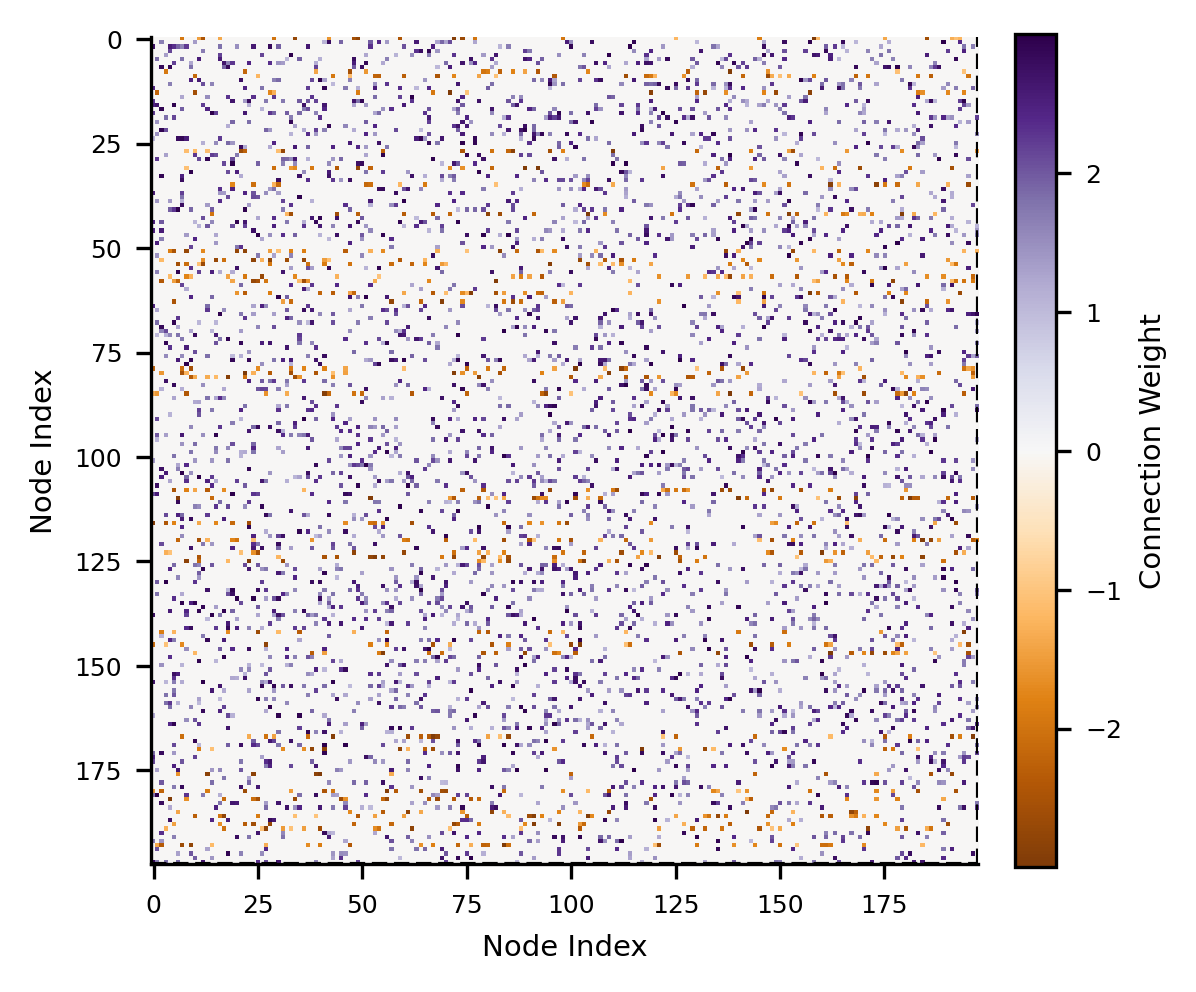

In [ ]:
plot_adjacency_matrix(post_G_reconstructed )
plt.show()

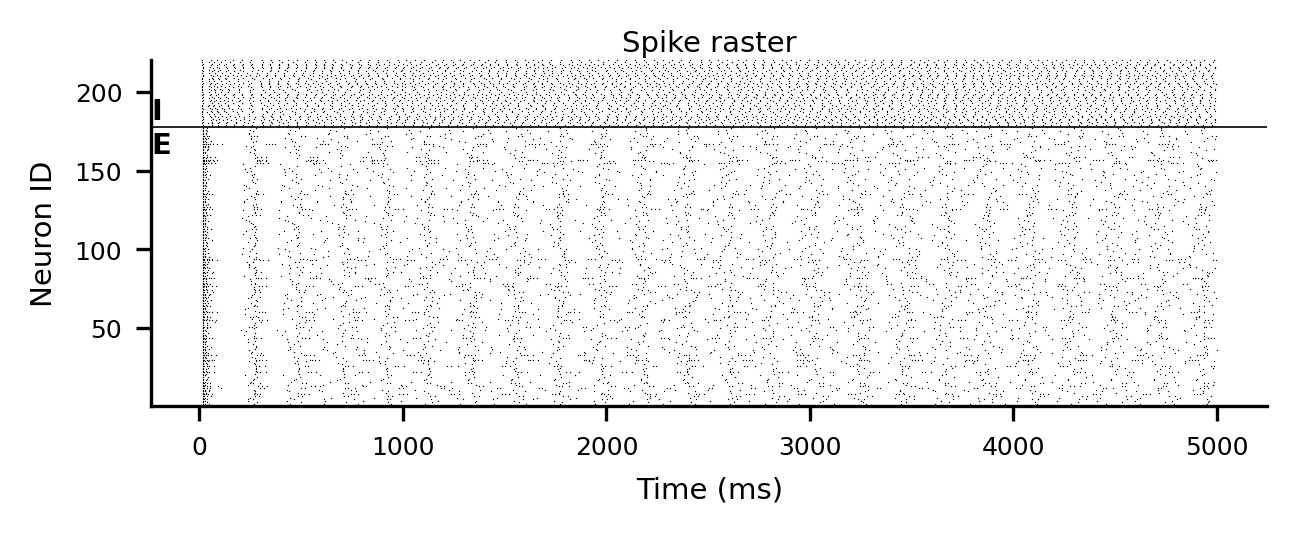

In [47]:
fig, ax_raster,orders = plot_raster(base_S_hist, neuron_type, W0,5000, mode='mask')

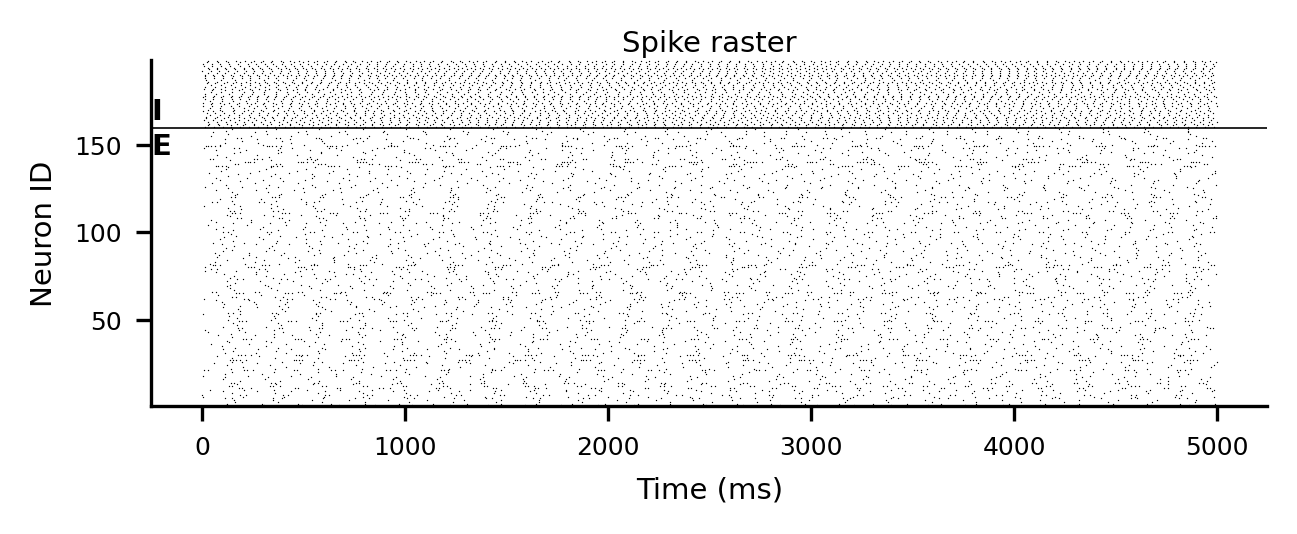

In [48]:
fig, ax_raster,orders = plot_raster(post_attack_S, neuron_type[take_idx], post_attack_W, 5000, mode='mask')

In [49]:
# syn_hist: shape (time, neurons)  -- adapt if you have (neurons, time)
mean_abs_syn = np.mean(np.abs(base_syn_hist))      # average across time & neurons
I_ext = 10.0
syn_to_ext_ratio = mean_abs_syn / I_ext 
syn_to_ext_ratio

np.float32(0.060762655)

In [36]:
(10 + abs(base_syn_hist.sum(axis=1)).mean())/10

Array(4.320251, dtype=float32)

In [24]:
import sys
import numpy as np

# Create a Python list of integers
py_list = list(range(10**6))

# Create a NumPy array of integers
np_array = np.arange(10**6)

# Memory usage
py_list_mem = sys.getsizeof(py_list) + sum(sys.getsizeof(x) for x in py_list)
np_array_mem = sys.getsizeof(np_array)

print(f"Python list memory: {py_list_mem / 1024**2:.2f} MB")
print(f"NumPy array memory: {np_array_mem / 1024**2:.2f} MB")


Python list memory: 34.33 MB
NumPy array memory: 7.63 MB


In [58]:
import sys
import numpy as np

# List of dictionaries
dict_list = [{"value": i} for i in range(10**6)]

# NumPy array
np_array = np.arange(10**6)

# Memory usage for dict list
dict_list_mem = sys.getsizeof(dict_list) + sum(sys.getsizeof(d) + sum(sys.getsizeof(k) + sys.getsizeof(v) for k, v in d.items()) for d in dict_list)

# Memory usage for NumPy array
np_array_mem = sys.getsizeof(np_array)

print(f"List of dicts memory: {dict_list_mem / 1024**2:.2f} MB")
print(f"NumPy array memory: {np_array_mem / 1024**2:.2f} MB")


List of dicts memory: 254.11 MB
NumPy array memory: 7.63 MB
